# ENGR 520 Homework 2 Exercise 2-1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io
from pydmd import DMD, plotter

In [2]:
# Load data
def load_mat_as_variables(file_path):
    mat_data = scipy.io.loadmat(file_path)
    for key, value in mat_data.items():
        if not key.startswith("__"):  # skip metadata keys
            globals()[key] = value

file_path = "CYLINDER_ALL.mat"
load_mat_as_variables(file_path)

# Reshape
m = m[0][0]
n = n[0][0]
nx = nx[0][0]
ny = ny[0][0]

| **Variable** | **Type**          | **Description**          |
| ------------ | ----------------- | ------------------------ |
| `UALL`       | 89351 x 151 array | $\boldsymbol{u}(t)$      |
| `UEXTRA`     | 89351 x 1 array   | $\boldsymbol{u}_0$       |
| `VALL`       | 89351 x 151 array | $\boldsymbol{v}(t)$      |
| `VEXTRA`     | 89351 x 1 array   | $\boldsymbol{v}_0$       |
| `VORTALL`    | 89351 x 151 array | $\boldsymbol{\omega}(t)$ |
| `VORTEXTRA`  | 89351 x 1 array   | $\boldsymbol{\omega}_0$  |
| `m`          | int               | domain width             |
| `n`          | int               | domain height            |
| `nx`         | int               | domain width             |
| `ny`         | int               | domain height            |

In [3]:
# Plotting functions
def plot_frame(frame, title="", clim=None):
    if clim:
        values = np.linspace(*clim, 1000)
        norm = matplotlib.colors.Normalize(*clim)
    else:
        values = None
        norm = None
    fig, ax = plt.subplots(figsize=(5, 1.5))
    im = ax.imshow(np.rot90(np.reshape(frame, (ny, nx))), origin="lower", cmap="seismic")
    fig.colorbar(im, values=values, location="left")
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return fig, ax


def plot_eigs(eigs, title=""):
    fig, ax = plt.subplots(figsize=(5, 3)
                           )
    ax.add_patch(plt.Circle((0, 0), 1, color="green", fill=False, label="Unit circle", linestyle="--"))
    ax.scatter(np.real(eigs), np.imag(eigs), c="b", marker="+", label="Eigenvalues")
    ax.legend(loc="upper right")
    ax.set_xlabel("real part")
    ax.set_ylabel("imaginary part")
    limit = np.max(np.ceil(np.absolute(eigs)))
    ax.set_xlim((-limit, limit))
    ax.set_ylim((-limit, limit))
    ax.axis('equal')
    ax.set_title(title)
    ax.grid(True)
    return fig, ax


def plot_modes(modes, title=""):
    mask = [-1] + list(range(len(modes.T)-2, 0, -2))
    figs = []
    axs = []
    for idx, mode in enumerate(modes.T[mask]):
        fig, ax = plot_frame(np.real(mode), title=title+f" Mode {idx}")
        figs.append(fig)
        axs.append(ax)
    return figs, axs


def plot_compare_eigs(eigs_1, eigs_2, label_1="" , label_2="", title=""):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.add_patch(plt.Circle((0, 0), 1, color="green", fill=False, label="Unit circle", linestyle="--"))
    ax.scatter(np.real(eigs_1), np.imag(eigs_1), marker="o", edgecolor="k", facecolor="none", label=label_1)
    ax.scatter(np.real(eigs_2), np.imag(eigs_2), c="b", marker="+", label=label_2)
    ax.legend(loc="upper right")
    ax.set_xlabel("real part")
    ax.set_ylabel("imaginary part")
    limit = np.max(np.ceil(np.absolute(np.concatenate((eigs_1, eigs_2)))))
    ax.set_xlim((-limit, limit))
    ax.set_ylim((-limit, limit))
    ax.axis('equal')
    ax.set_title(title)
    ax.grid(True)
    return fig, ax

## a. Clean Data

In [4]:
dmd = DMD(svd_rank=21, sorted_eigs="real")
dmd.fit(VORTALL)
eigs_clean = dmd.eigs

/home/exurl/anaconda3/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 9585725.906000633. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


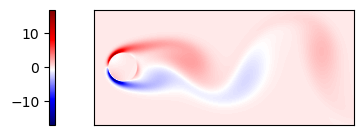

In [5]:
# Plot snapshot
fig_snapshot, _ = plot_frame(VORTALL[:, 0], clim=(-17, 17))
fig_snapshot.savefig(f"fig1a_snapshot.pdf", bbox_inches="tight")

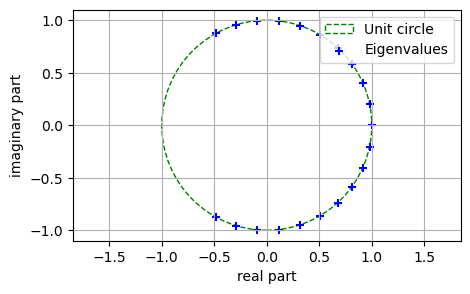

In [6]:
# Plot eigenvalues
fig, _ = plot_eigs(dmd.eigs)
fig.savefig("fig1a_eigs.pdf", bbox_inches="tight")

## b. Noisy Data

In [7]:
# Initialize RNG
rng = np.random.default_rng()

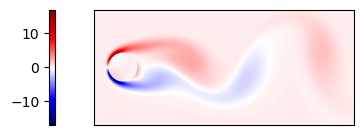

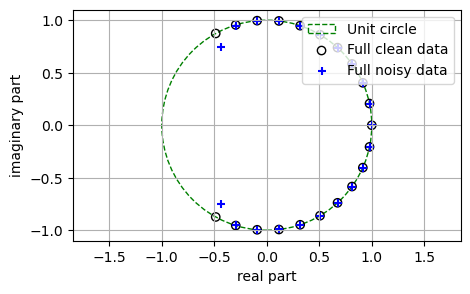

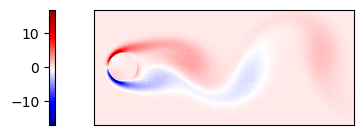

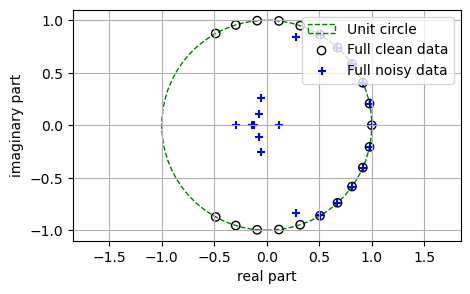

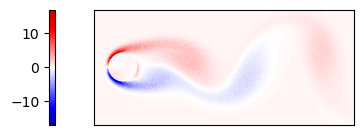

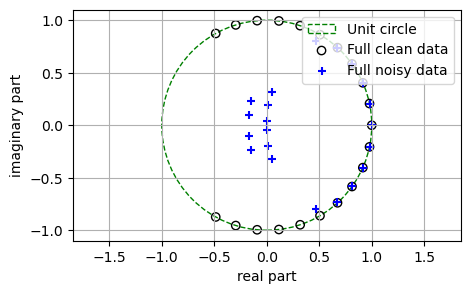

In [8]:
noise_magnitudes = [0.01, 0.1, 0.2]
for idx, noise_mag in enumerate(noise_magnitudes):
    # Create noisy data
    scale = noise_mag * np.linalg.norm(VORTALL) / np.sqrt(VORTALL.size)
    VORTALL_noisy = VORTALL + VORTALL * rng.normal(loc=0, scale=scale, size=VORTALL.shape)

    # Compute DMD
    dmd = DMD(svd_rank=21, sorted_eigs="real")
    dmd.fit(VORTALL_noisy)
    
    # Plot snapshot
    fig_snapshot, _ = plot_frame(VORTALL_noisy[:, 0], clim=(-17, 17))
    fig_snapshot.savefig(f"fig1b_snapshot_{idx+1}.pdf", bbox_inches="tight")

    # Plot eigenvalues
    fig_eigs, _ = plot_compare_eigs(eigs_clean, dmd.eigs, "Full clean data", "Full noisy data")
    fig_eigs.savefig(f"fig1b_eigs_{idx+1}.pdf", bbox_inches="tight")
    

## c. Clean Data Subset

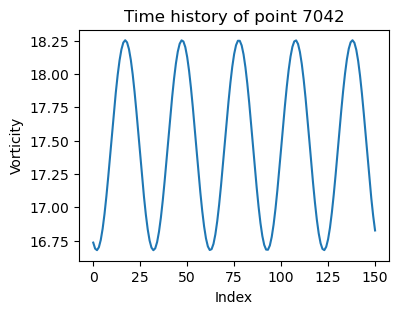

In [9]:
# Plot oscillation over time
idx_pt = np.argmax(VORTALL[:, 0])
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(VORTALL[idx_pt, :])
plt.xlabel("Index")
plt.ylabel("Vorticity")
plt.title(f"Time history of point {idx_pt}")
plt.show()

In [10]:
# Determine vortex shedding period
vort_fft = np.abs(np.fft.fft(VORTALL[idx_pt, :]))
idx = np.argmax(vort_fft)
multiple = vort_fft[idx]
period = len(VORTALL) / multiple

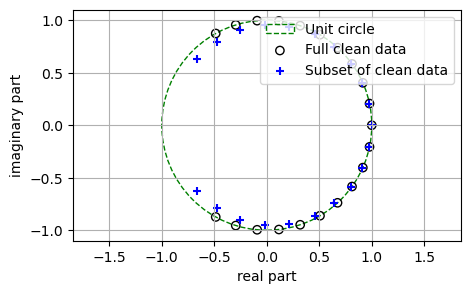

In [11]:
# Create subset data
idx_end = round(period * 0.75)
VORTALL_subset = VORTALL[:, :idx_end]

# Compute DMD
dmd = DMD(svd_rank=21, sorted_eigs="real")
dmd.fit(VORTALL_subset)

# Plot eigenvalues
fig, _ = plot_compare_eigs(eigs_clean, dmd.eigs, "Full clean data", "Subset of clean data")
fig.savefig(f"fig1c_eigs.pdf", bbox_inches="tight")